In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import inspect
import sympy
from sympy.utilities.lambdify import lambdify
sympy.init_printing()

### Загружаємо дані та візуалізуємо їх

In [2]:
data = pd.read_csv('v14.csv')

In [3]:
data

,Price,Demand,Supply
0,7.0,183,5
1,8.5,160,19
2,9.3,141,41
3,10.0,135,55
4,11.0,121,70
5,12.3,102,93
6,13.1,80,123
7,14.0,58,155
8,15.8,44,174
9,16.5,21,199


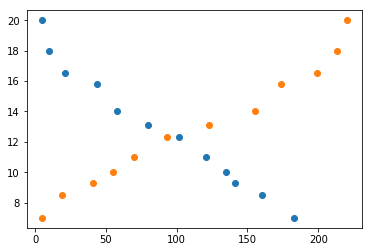

In [4]:
plt.plot(data['Demand'].values, data['Price'].values, 'o')
plt.plot(data['Supply'].values, data['Price'].values, 'o')
plt.show()

In [5]:
# Необхідні константи
p_dens = 200
min_pr, max_pr = data.iloc[0]['Price'], data.iloc[-1]['Price']
prices = np.linspace(min_pr, max_pr, p_dens)

## Знаходження аналітичного вигляду функція попиту та пропозиції
Функції попиту та пропозиції будемо знаходити у вигляді: 
\begin{align}
Q=\alpha f(P)+\beta
\end{align}
де $f$ задовольняє наступним властивостям.

Для функції попиту:
\begin{align}
\frac{\partial f}{\partial P} &< 0 \\
\frac{\partial^2 f}{\partial P^2} &>= 0
\end{align}
Для функції пропозиції:
\begin{align}
\frac{\partial f}{\partial P} &> 0 \\
\frac{\partial^2 f}{\partial P^2} &<= 0
\end{align}

Знайдемо значення $\alpha$ та $\beta$ за допомогою лінійної регресії з квадратичною функцією втрат. \\
Нехай дано вибірку $Q^*$, $P^*$. Тоді потрібно мінімізувати функціонал:
\begin{align}
L(P^*,Q^*)=(\alpha f(P^*)+\beta - Q^*)^T(\alpha f(P^*)+\beta - Q^*)
\end{align}
Тоді параметри набувають вигляду:
\begin{align}
(\alpha, \beta) &= (X^T X)^{-1} X^T Q^*\\
X &= \begin{bmatrix}f(P^*_1) & 1\\f(P^*_2) & 1\\... & ... \\ f(P^*_n) & 1\end{bmatrix} \\
\end{align}
$n$ - кількість елементів у вибірці

Модель лінійної регресії реалізована в класі sklearn.linear_model.LinearRegression.

### Вибір функції f
Функцію $f$ будемо вибирати перебором. Визначимо множини функцій $f_{d\_set}$ та $f_{s\_set}$. Виберемо по одній функції з цих множин які максимізують значення коефіцієнта детермінації.

In [6]:
# Generate X matrix from P
def generate_features(X, f):
    X = X.reshape(-1, 1)
    return np.concatenate([f(X), np.ones(X.shape)], axis=1)

# Find function that fits dataset the best
def best_f(X, y, f_set):
    curr_max = -1e9
    max_ind = 0
    for ind, f in enumerate(f_set):
        model = LinearRegression()
        generated_features = generate_features(X, f)
        model.fit(generated_features, y)
        curr_score = model.score(generated_features, y)
        if curr_score > curr_max:
            max_ind = ind
            curr_max = curr_score
    return f_set[max_ind]

In [7]:
# Model of demand/supply dependence from price as Q=a*f(P)+b
class QModel:
    # Choose function that fits dataset the best from f_set and train model
    def __init__(self, P, Q, f_set, is_demand):
        # Symbols for printing and differentiation
        self._P = sympy.symbols('P')
        self._Q = sympy.symbols('Q_' + ('d' if is_demand else 's'))
        self._E = sympy.symbols('E_' + ('d' if is_demand else 's'))
        
        self.f = best_f(P, Q, f_set)
        
        self._regression = LinearRegression(fit_intercept=False)
        self._regression.fit(generate_features(P, self.f), Q)
        
        # Demand/Supply function
        self.Q_f = lambda P: self._regression.coef_[0] * self.f(P) + self._regression.coef_[1]
        
        # Elasticity function
        self._elasticity = sympy.diff(self.Q_f(self._P), self._P) * self._P / self.Q_f(self._P)
        # lambdified elasticity function for faster usage
        self.elasticity = lambdify(self._P, self._elasticity)
        
        #Definitions for pretty output
        self._pretty_Q_f = round(self._regression.coef_[0], 2) * self.f(self._P) + round(self._regression.coef_[1], 2)
        self._pretty_elasticity = sympy.diff(self._pretty_Q_f, self._P) * self._P / self._pretty_Q_f
        
    def pretty_print(self):
        return sympy.Eq(self._Q, self._pretty_Q_f)
    
    def pretty_print_elasticity(self):
        return sympy.Eq(self._E, self._pretty_elasticity)
    
    def __call__(self, P):
        return self.Q_f(np.array(P))
        
    
    def arc_elasticity(self, P): # returns len(values) - 1 numbers
        p1, p2 = P[:-1], P[1:]
        f1, f2 = self(p1), self(p2)
        return (f2 - f1) / (p2 - p1) * (p2 + p1) / (f2 + f1)

# Апроксимація попиту

In [8]:
f_d_set = [
    lambda x: 1 / x,
    lambda x: 1 / (x ** (1/2)),
    lambda x: 1 / (x ** (1/3)),
    lambda x: 1 / (x ** (1/4)),
    lambda x: 1 / np.log(x)
]

In [9]:
Q_d = QModel(data['Price'].values, data['Demand'].values, f_d_set, is_demand=True)

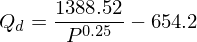

In [10]:
Q_d.pretty_print()

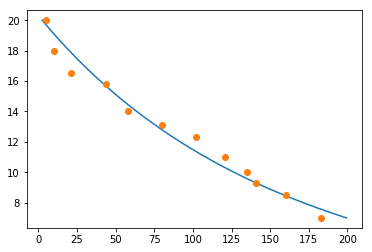

In [11]:
plt.plot(Q_d(prices), prices)
plt.plot(data['Demand'], data['Price'], 'o')
plt.show()

# Апроксимація пропозиції

In [12]:
f_s_set = [
    lambda x: x ** (1/2),
    lambda x: x ** (1/3),
    lambda x: x ** (1/4),
    lambda x: np.log(x)
]

In [13]:
Q_s = QModel(data['Price'].values, data['Supply'].values, f_s_set, is_demand=False)

In [14]:
Q_s.pretty_print()

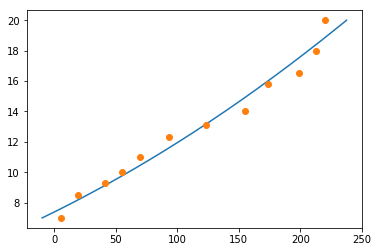

In [15]:
plt.plot(Q_s(prices), prices)
plt.plot(data['Supply'], data['Price'], 'o')
plt.show()

# Точка ринкової рівноваги

In [16]:
def intersection(f1, f2, values):
    ind = np.argmin(np.abs(f1(values) - f2(values)))
    return (values[ind], ((f1(values[ind:ind+1]) + f2(values[ind:ind+1])) / 2)[0])

In [17]:
balance_point = intersection(Q_d, Q_s, prices)

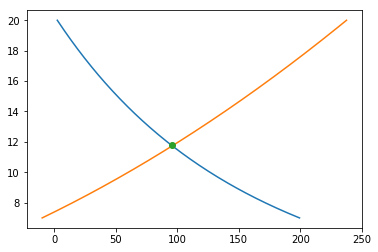

Точка ринкової рівноваги. P:12.0, Q:96.0


In [18]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(balance_point[1], balance_point[0], 'o')
plt.show()
print("Точка ринкової рівноваги. P:{}, Q:{}".format(round(balance_point[0]), round(balance_point[1])))

### Cтійкість точки рівноваги

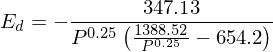

In [19]:
Q_d.pretty_print_elasticity()

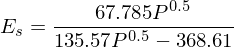

In [20]:
Q_s.pretty_print_elasticity()

In [21]:
bal_elasticity = Q_d.elasticity(balance_point[0]), Q_s.elasticity(balance_point[0])

In [22]:
print("Еластичність в точці рівноваги:\nПопиту: {}\nПропозиції: {}".format(bal_elasticity[0], bal_elasticity[1]))

Еластичність в точці рівноваги:
Попиту: -1.963199544466674
Пропозиції: 2.4101341916053043


In [23]:
is_stable = np.fabs(bal_elasticity[0]) > np.fabs(bal_elasticity[1])

In [24]:
print("Точка ринкової рівноваги {}стабільна".format("" if is_stable else "не "))

Точка ринкової рівноваги не стабільна


# Дугова еластичність

### Попит

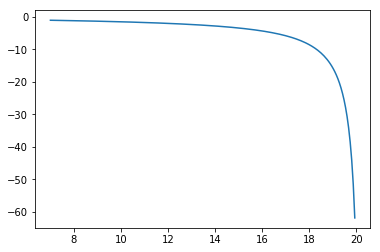

In [25]:
plt.plot(prices[:-1], Q_d.arc_elasticity(prices))
plt.show()

In [26]:
print("Попит {}є еластичним".format("" if np.all(abs(Q_d.arc_elasticity(prices)) > 1) else "не "))

Попит є еластичним


### Пропозиція

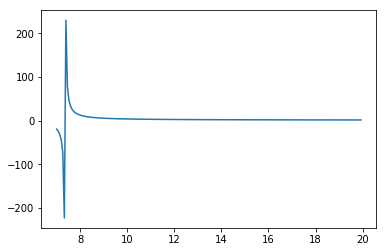

In [27]:
plt.plot(prices[:-1], Q_s.arc_elasticity(prices))
plt.show()

In [28]:
print("Пропозиція {}є еластичною".format("" if np.all(abs(Q_s.arc_elasticity(prices)) > 1) else "не "))

Пропозиція є еластичною


# Вплив держави на ціни
### Податок та субсидії на одну із сторін (споживач, виробник)

In [29]:
bal_tax_dem = bal_tax_sup = bal_tax_dem = bal_tax_sub = (-1, -1)

In [30]:
tax_dem = 5
tax_sup = 5
subsidy_dem = 5
subsidy_sup = 5

In [31]:
Q_d_tax = lambda p: Q_d(p - tax_dem)
Q_d_subsidy = lambda p,: Q_d(p + subsidy_dem)
Q_s_tax = lambda p: Q_s(p - tax_sup)
Q_s_subsidy = lambda p: Q_s(p + subsidy_sup)

In [32]:
bal_tax_dem = intersection(Q_d_tax, Q_s, prices)
bal_tax_sup = intersection(Q_d, Q_s_tax, prices)
bal_subsidy_dem = intersection(Q_d_subsidy, Q_s, prices)
bal_subsidy_sup = intersection(Q_d, Q_s_subsidy, prices)

In [33]:
bal_points1 = [bal_tax_dem, bal_subsidy_sup, bal_tax_sup, bal_subsidy_dem]

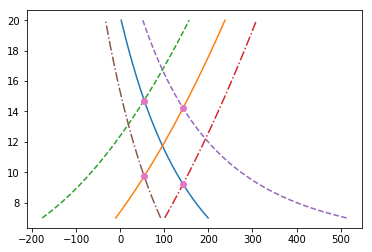

Точка ринкової рівноваги при податку зі сторони споживача 5. P:14.0, Q:143.0
Точка ринкової рівноваги при податку зі сторони виробника 5. P:15.0, Q:54.0
Точка ринкової рівноваги при субсидіях зі сторони споживача 5. P:10.0, Q:54.0
Точка ринкової рівноваги при субсидіях зі сторони виробника 5. P:9.0, Q:143.0


In [34]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_s_tax(prices), prices, '--')
plt.plot(Q_s_subsidy(prices), prices, '-.')
plt.plot(Q_d_tax(prices), prices, '--')
plt.plot(Q_d_subsidy(prices), prices, '-.')
plt.plot([p[1] for p in bal_points1], [p[0] for p in bal_points1], 'o')
plt.show()
print("Точка ринкової рівноваги при податку зі сторони споживача {}. P:{}, Q:{}".format(tax_dem, round(bal_tax_dem[0]), round(bal_tax_dem[1])))
print("Точка ринкової рівноваги при податку зі сторони виробника {}. P:{}, Q:{}".format(tax_sup, round(bal_tax_sup[0]), round(bal_tax_sup[1])))
print("Точка ринкової рівноваги при субсидіях зі сторони споживача {}. P:{}, Q:{}".format(subsidy_dem, round(bal_subsidy_dem[0]), round(bal_subsidy_dem[1])))
print("Точка ринкової рівноваги при субсидіях зі сторони виробника {}. P:{}, Q:{}".format(subsidy_sup, round(bal_subsidy_sup[0]), round(bal_subsidy_sup[1])))

### Квота з еквівалентним податком та субсидією

In [50]:
eq_tax = 2.5
eq_subsidy = 2.5
quote = 70

In [51]:
def Q_s_quote(P):
    Q = Q_s(P)
    Q[Q > quote] = quote
    return Q

In [52]:
Q_d_eq_tax = lambda P: Q_d(P - eq_tax)
Q_d_eq_subsidy = lambda P: Q_d(P + eq_subsidy)
Q_s_eq_tax_quote = lambda P: Q_s_quote(P - eq_tax)
Q_s_eq_subsidy_quote = lambda P: Q_s_quote(P + eq_subsidy)

In [53]:
bal_eq_tax = intersection(Q_d_eq_tax, Q_s_eq_tax_quote, prices)
bal_eq_subsidy = intersection(Q_d_eq_subsidy, Q_s_eq_subsidy_quote, prices)

In [54]:
bal_points2 = [bal_eq_tax, bal_eq_subsidy]

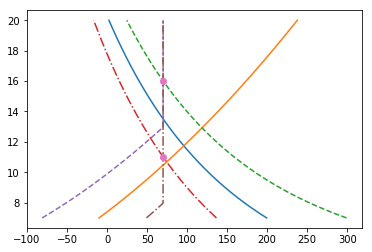

Точка ринкової рівноваги при квоті 70 та еквівалентному податку 2.5. P:16.0, Q:70.0
Точка ринкової рівноваги при квоті 70 та еквівалентних субсидіях 2.5. P:11.0, Q:70.0


In [56]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_d_eq_tax(prices), prices, '--')
plt.plot(Q_d_eq_subsidy(prices), prices, '-.')
plt.plot(Q_s_eq_tax_quote(prices), prices, '--')
plt.plot(Q_s_eq_subsidy_quote(prices), prices, '-.')
plt.plot([p[1] for p in bal_points2], [p[0] for p in bal_points2], 'o')
plt.show()
print("Точка ринкової рівноваги при квоті {} та еквівалентному податку {}. P:{}, Q:{}".format(quote, eq_tax, round(bal_eq_tax[0]), round(bal_eq_tax[1])))
print("Точка ринкової рівноваги при квоті {} та еквівалентних субсидіях {}. P:{}, Q:{}".format(quote, eq_tax, round(bal_eq_subsidy[0]), round(bal_eq_subsidy[1])))